In [1]:
! pip install langchain_community langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 445.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.9/394.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [2]:
%pip install -qU langchain_community pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 12.9 MB/s eta 0:00:00


In [3]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(
    "/content/HAI_2024_AI-Index-Report.pdf",
)

In [4]:
docs=loader.load()

In [5]:
%pip install -qU langchain-text-splitters

In [7]:
from langchain_text_splitters import CharacterTextSplitter


In [8]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)

In [9]:
docs=text_splitter.split_documents(docs)

In [10]:
import getpass

inference_api_key = getpass.getpass("Enter your HF Inference API Key:\n\n")

Enter your HF Inference API Key:

··········


In [11]:
from langchain_community.embeddings import HuggingFaceInferenceAPIEmbeddings

embeddings = HuggingFaceInferenceAPIEmbeddings(
    api_key=inference_api_key, model_name="sentence-transformers/all-MiniLM-l6-v2"
)

In [17]:
pip install -qU langchain-community faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 32.7 MB/s eta 0:00:00


In [18]:
import faiss
#from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

In [19]:
db=FAISS.from_documents(docs,embeddings)

In [64]:
retriever=db.as_retriever()

In [21]:
# Retrival Grader

In [22]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [23]:
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [13]:
import getpass
import os

os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

Enter your Groq API key: ··········


In [15]:
%pip install -qU langchain-groq
from langchain_groq import ChatGroq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 6.5 MB/s eta 0:00:00


In [27]:
llm=ChatGroq( model="llama-3.1-8b-instant",temperature=0)

In [28]:
structured_llm_grader = llm.with_structured_output(GradeDocuments)

In [29]:
# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [65]:
retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [31]:
# Genration

In [35]:
LANGCHAIN_TRACING_V2="true"
LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
LANGCHAIN_API_KEY="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"
LANGCHAIN_PROJECT="Crag"

In [36]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

In [37]:
prompt = hub.pull("rlm/rag-prompt")

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:333: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [38]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))])

In [40]:
question="How has AI affected us"

In [41]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

AI has significantly affected us by enabling the development of autonomous or semiautonomous systems, known as AI agents, which can operate within specific environments to accomplish goals. These agents have diverse applications, from assisting in academic research to facilitating online shopping and vacation booking. Emerging research suggests that the performance of autonomous AI agents is improving, with current agents mastering complex games like Minecraft and tackling real-world tasks effectively.


In [42]:
# Question Re-writer

In [43]:
# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'Here\'s a re-written version of the question that\'s optimized for web search:\n\n"What are the significant impacts of artificial intelligence on society and human life?"\n\nThis revised question:\n\n1. Uses more specific keywords ("artificial intelligence", "society", "human life") that are likely to be used in relevant search results.\n2. Adds a sense of scope and scale ("significant impacts") to help search engines understand the type of information being sought.\n3. Uses more formal and descriptive language, making it easier for search engines to understand the intent behind the question.\n\nAlternatively, you could also try:\n\n* "How has the development of artificial intelligence influenced modern life?"\n* "What are the effects of artificial intelligence on human behavior and relationships?"\n* "What are the benefits and drawbacks of artificial intelligence on society?"\n\nEach of these revised questions aims to capture the underlying semantic intent of the original question wh

In [ ]:
#The code takes an initial question, passes it through a GPT-3.5 model that has been instructed to rewrite the question in a way that makes it better suited for web search. The final output is the improved question.

In [44]:
# External Search

In [45]:
%pip install -qU "langchain-community>=0.2.11" tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.1 MB/s eta 0:00:00


In [46]:
import getpass
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

Tavily API key:
··········


In [67]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [68]:
## Langgraph

In [69]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [79]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    #docs = web_search_tool.invoke({"query": question})         # If you have dict of documents or pdf (multiple pdfs stored in dict) then use this code
    #web_results = "\n".join([d["content"] for d in docs])
    #web_results = Document(page_content=web_results)
    #documents.append(web_results)

    docs=web_search_tool.invoke({"query": question})       # For single pdf
    web_results=docs

    return {"documents": documents, "question": question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [54]:
pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.7/87.7 kB 5.3 MB/s eta 0:00:00


In [80]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

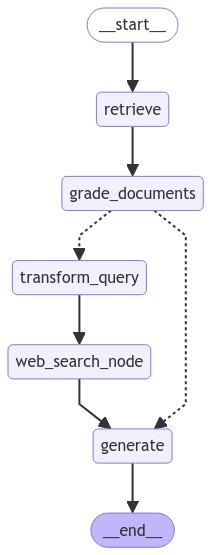

In [81]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [82]:
question = "How has AI affected us"

# Run the workflow
result = app.invoke({"question": question})

# Print the result
print(result["generation"])


---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
AI has had a significant impact on people's lives, with 66% of respondents believing it will dramatically affect their lives in the next three to five years. However, the public is also nervous about AI, with 52% expressing nervousness towards AI products and services. Demographic differences exist in perceptions of AI's potential, with younger generations and those with higher incomes and education levels being more optimistic.


In [77]:
if result["web_search"] == "Yes":
  print("Web search was performed.")
else:
  print("RAG was performed.")


RAG was performed.


In [83]:
question = "What are transformer models and which was the first transfromer model"

# Run the workflow
result = app.invoke({"question": question})

# Print the result
print(result["generation"])


---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
---WEB SEARCH---
---GENERATE---
The first transformer model developed is the original Transformer, released in 2017. It required around 7,400 petaFLOPs for training. The key features of this model are not explicitly mentioned in the provided context.


In [90]:
question = "What is this chatbot about"

# Run the workflow
result = app.invoke({"question": question})

# Print the result
print(result["generation"])


---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
This chatbot is about discussing various aspects of Artificial Intelligence (AI), including its applications, challenges, and potential risks. It covers topics such as self-driving cars, romantic AI chatbots, and language models, highlighting both their capabilities and limitations. The chatbot appears to be based on the AI Index Report 2024.


In [ ]:
####

Output Logs:

---RETRIEVE---: The workflow begins by retrieving documents that might answer the question. This could involve searching a database or using a pre-existing set of documents.

---CHECK DOCUMENT RELEVANCE TO QUESTION---: The workflow checks the relevance of each retrieved document against the question. This step is crucial in determining which documents are likely to contain the answer.

---GRADE: DOCUMENT NOT RELEVANT---: The system grades each document's relevance to the question. Here, it found some documents that were not relevant.

---GRADE: DOCUMENT RELEVANT---: The system also found at least one document that was relevant.

---ASSESS GRADED DOCUMENTS---: After grading all documents, the workflow assesses the overall relevance. This step likely aggregates the relevance scores or makes a decision based on how many relevant documents were found.

---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---: Despite finding some relevant documents, the workflow decided that the set of documents as a whole was not relevant enough to answer the question. Therefore, it opts to transform the original query to improve the search results.

---TRANSFORM QUERY---: The workflow modifies the original question to better align with the documents available or to improve the quality of the subsequent web search.

---WEB SEARCH---: The transformed query is then used to perform a web search. This step likely involves searching the web for documents that better answer the question.

---GENERATE---: Finally, after retrieving and assessing new documents, the workflow generates a response to the original question.